In [1]:
import sys
print(sys.executable)

# this prevents the need to restart the kernel every time a local module is changed
%load_ext autoreload
%autoreload 2

/grad/sguotong/.conda/envs/.cavGZ_venv/bin/python


In [2]:
from bessel import initialize_bessel_table, BesselJZeros, BesselJpZeros
initialize_bessel_table(10, 10)

# print out a table of BesselJZeros
print("BesselJZeros (m,n): \n")
print("k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |\n")
for n in range(1, 6):
    str_out = f"{n} |"
    for m in range(0, 6):
        str_out += f" {BesselJZeros(m, n):.5f} |"

    print(str_out)

print("\n https://mathworld.wolfram.com/BesselFunctionZeros.html")

BesselJZeros (m,n): 

k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |

1 | 2.40483 | 3.83171 | 5.13562 | 6.38016 | 7.58834 | 8.77148 |
2 | 5.52008 | 7.01559 | 8.41724 | 9.76102 | 11.06471 | 12.33860 |
3 | 8.65373 | 10.17347 | 11.61984 | 13.01520 | 14.37254 | 15.70017 |
4 | 11.79153 | 13.32369 | 14.79595 | 16.22347 | 17.61597 | 18.98013 |
5 | 14.93092 | 16.47063 | 17.95982 | 19.40942 | 20.82693 | 22.21780 |

 https://mathworld.wolfram.com/BesselFunctionZeros.html


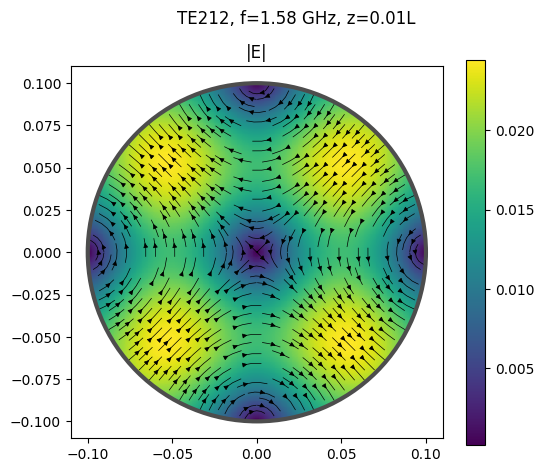

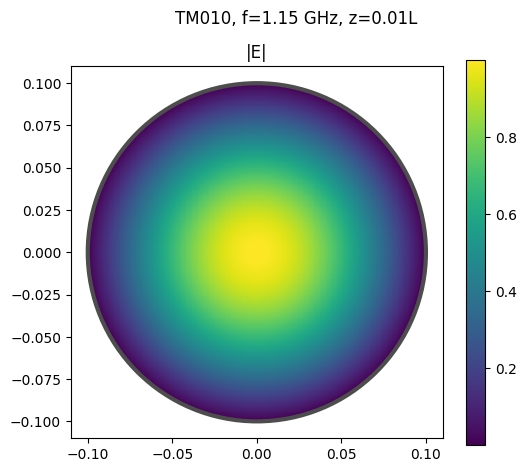

In [3]:
from cavity_modes import CavityModeHelper
import numpy as np
import matplotlib.pyplot as plt

a = 0.1  # radius in meters
L = 0.5  # length in meters
family = "TE"
m, n, p = 2, 1, 2
sign = "-"
cavHelper = CavityModeHelper(a, L)
w_TE212 = cavHelper.omega_mnp(family, m, n, p)
f_TE212 = w_TE212/(2*np.pi)*0.3  # in GHz
Er, Ephi, Ez = cavHelper.mode_fn_callables(family, m, n, p, sign)

# plot a slice near z=0
# THIS SHOULD BE MOVED TO A HELPER FILE IN THE FUTURE
def plot_disk_slice(Fr, Fphi, Fz, a, z0, *, r_pts=200, ph_pts=200, title="", func_name="", show_components=False):
    x = np.linspace(-a, a, 2*r_pts)
    y = np.linspace(-a, a, 2*r_pts)
    X, Y = np.meshgrid(x, y, indexing="xy")
    R = np.hypot(X, Y)
    Phi = np.arctan2(Y, X)
    Z = np.full_like(R, z0)
    disk = R <= a
    eps = 1e-6

    Frv = Fr(R, Phi, Z)
    Fphiv = Fphi(R, Phi, Z)
    Fzv = Fz(R, Phi, Z)

    Fr_real, Fr_imag, Fr_mag = np.real(Frv), np.imag(Frv), np.abs(Frv)
    Fphi_real, Fphi_imag, Fphi_mag = np.real(Fphiv), np.imag(Fphiv), np.abs(Fphiv)
    Fz_real, Fz_imag, Fz_mag = np.real(Fzv), np.imag(Fzv), np.abs(Fzv)
    norm = np.sqrt(Fr_mag**2 + Fphi_mag**2 + Fz_mag**2)

    # one plot of the norm
    fig2, ax2 = plt.subplots(figsize=(6, 5))
    norm = np.where(disk, norm, np.nan)
    plt_norm = ax2.pcolormesh(X, Y, norm, shading="auto", cmap="viridis", zorder=1)
        # vector plot on top of norm plot
    Fx = Fr_imag * np.cos(Phi) - Fphi_imag * np.sin(Phi)
    Fy = Fr_imag * np.sin(Phi) + Fphi_imag * np.cos(Phi)
    Fxy_mag = np.sqrt(Fx**2 + Fy**2) + eps
    Fx /= Fxy_mag
    Fy /= Fxy_mag
            # mask outside the disk and avoid singular arrows near |F|≈0

    U = np.where(disk, Fx, np.nan)
    V = np.where(disk, Fy, np.nan)
    M = np.where(disk, Fxy_mag, np.nan)
            # normalize stream directions
    L = np.sqrt(U**2 + V**2)
    U = U / (L + eps)
    V = V / (L + eps)
    U[L < eps] = np.nan; V[L < eps] = np.nan
    sp = ax2.streamplot(
        X, Y, U, V,
        density=1.2,
        color="k",
        linewidth=0.5,
        arrowsize=0.7,
        minlength=0.05, maxlength=0.1,
        integration_direction="both",
        broken_streamlines=False,
        zorder=2,
    )

    ax2.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
    ax2.set_aspect("equal", "box")
    ax2.set_xlim(-1.1*a, 1.1*a); ax2.set_ylim(-1.1*a, 1.1*a)
    ax2.set_title(f"|{func_name}|")
    fig2.colorbar(plt_norm, ax=ax2)
    plt.suptitle(title or f"Disk slice at z={z0:.3g}")
    plt.show()

    if not show_components: return
    
    # plot 3*3 subplots of magnitude
    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    comp_dict = {
        "r": (Fr_real, Fr_imag, Fr_mag),
        "phi": (Fphi_real, Fphi_imag, Fphi_mag),
        "z": (Fz_real, Fz_imag, Fz_mag)
    }
    for i, key in enumerate(["r", "phi", "z"]):
        real, imag, mag = comp_dict[key]
        real = np.where(disk, real, np.nan)
        imag = np.where(disk, imag, np.nan)
        mag = np.where(disk, mag, np.nan)

        ax_real, ax_imag, ax_mag = axs[i, 0], axs[i, 1], axs[i, 2]
        plt_real = ax_real.pcolormesh(X, Y, real, shading="auto", cmap="viridis")
        ax_real.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_real.set_aspect("equal", "box")
        ax_real.set_xlim(-1.1*a, 1.1*a); ax_real.set_ylim(-1.1*a, 1.1*a)
        ax_real.set_title(f"Re({func_name}_{key})")

        plt_imag = ax_imag.pcolormesh(X, Y, imag, shading="auto", cmap="viridis")
        ax_imag.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_imag.set_aspect("equal", "box")
        ax_imag.set_xlim(-1.1*a, 1.1*a); ax_imag.set_ylim(-1.1*a, 1.1*a)
        ax_imag.set_title(f"Im({func_name}_{key})")

        plt_mag = ax_mag.pcolormesh(X, Y, mag, shading="auto", cmap="viridis")
        ax_mag.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_mag.set_aspect("equal", "box")
        ax_mag.set_xlim(-1.1*a, 1.1*a); ax_mag.set_ylim(-1.1*a, 1.1*a)
        ax_mag.set_title(f"|{func_name}_{key}|")

    fig.colorbar(plt_mag, ax=axs.ravel().tolist())
    plt.suptitle(title or f"Disk slice at z={z0:.3g}")
    plt.show()

z0_over_L = 0.01
z0 = z0_over_L * L
title = f"{family}{m}{n}{p}, f={f_TE212:.3g} GHz, z={z0_over_L:.3g}L"
plot_disk_slice(Er, Ephi, Ez, a, z0, title=title, func_name="E")

family = "TM"
m, n, p = 0, 1, 0
sign = "-"
w_TM010 = cavHelper.omega_mnp(family, m, n, p)
f_TM010 = w_TM010/(2*np.pi)*0.3  # in GHz
Er, Ephi, Ez = cavHelper.mode_fn_callables(family, m, n, p, sign)
title = f"{family}{m}{n}{p}, f={f_TM010:.3g} GHz, z={z0_over_L:.3g}L"
plot_disk_slice(Er, Ephi, Ez, a, z0, title=title, func_name="E")


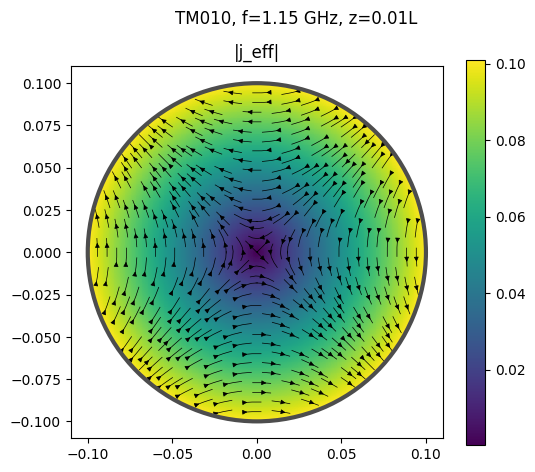

In [4]:
from j_eff import j_eff_callables

pol = "+"
Jr, Jphi, Jz = j_eff_callables(pol, w_TM010, 0, 0, 0)
plot_disk_slice(Jr, Jphi, Jz, a, z0, title=title, func_name="j_eff")

In [5]:
Nr, Nphi, Nz = 200, 256, 96
r = np.linspace(0.0, a, Nr, endpoint=True)
phi = np.linspace(0.0, 2*np.pi, Nphi, endpoint=False)
z = np.linspace(-L/2, +L/2, Nz, endpoint=True)

R, PHI, Z = np.meshgrid(r, phi, z, indexing="ij")   # shape: [Nr, Nphi, Nz]

family = "TE"
m, n, p = 2, 1, 1
sign = "-"

Er, Ephi, Ez = cavHelper.mode_fn_vectorized(R, PHI, Z, family, m, n, p, sign)
w_mnp = cavHelper.omega_mnp(family, m, n, p)
f_mnp = w_mnp/(2*np.pi)*0.3  # in GHz
print(f"{family}{m}{n}{p}, f={f_mnp:.3g} GHz")

TE211, f=1.49 GHz


In [14]:
from antenna_pattern import antenna_pattern
from custom_types import asarr_f64

Nb, Na, Npsi = 60, 1, 1
beta = np.linspace(0.0, np.pi, Nb, endpoint=True)
alpha = asarr_f64(0.0)  # single value for alpha for linear polarization
psi = asarr_f64(0.0)  # single value for psi for linear polarization

pol = "cross"

eta = antenna_pattern(r, phi, z, Er, Ephi, Ez, pol=pol, 
                      wg=w_mnp, a=a, L=L, beta=beta, alpha=alpha, psi=psi,
                      savefile="eta_TE212_cross.npy")


Norm is 0.002945558357496856
E shape after broadcasting: (200, 256, 96, 1, 1, 1)
Calculating j_eff...
j shape after broadcasting: (200, 256, 96, 60, 1, 1)
Finished j_eff calculation, starting integral...
Finished integral, starting eta calculation...
Finished eta calculation.
Saved eta to eta_TE212_cross.npy


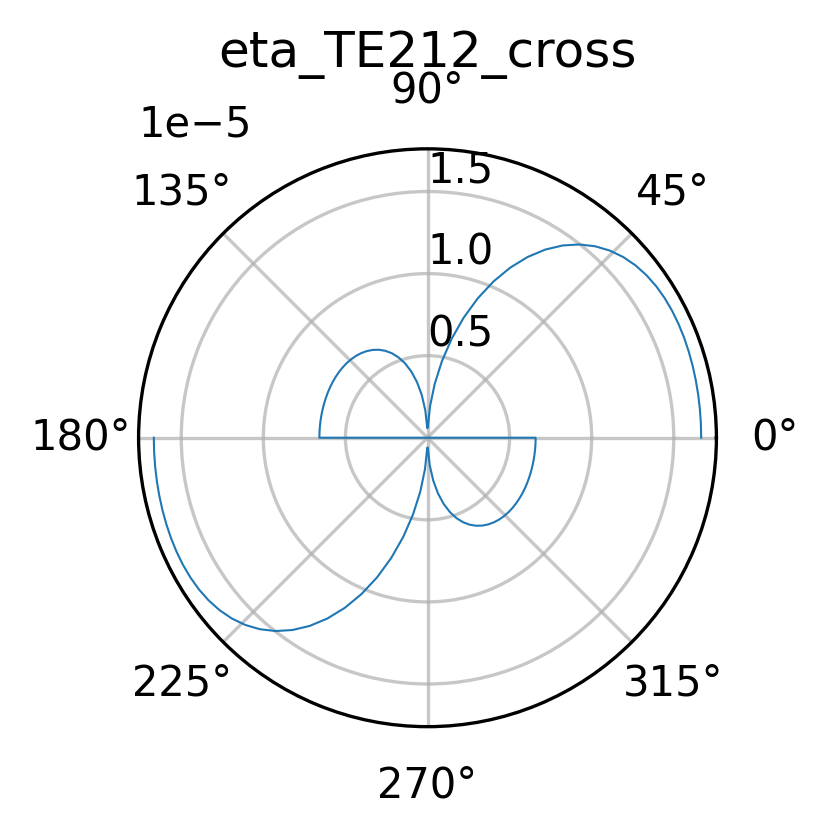

In [16]:
import numpy as np
import matplotlib.pyplot as plt

PATH = "eta_TE212_cross.npy"

eta = np.load(PATH)                        # shape (Nb, Na, Npsi)
curve = eta[:, 0, 0].astype(float)         # take α=0, ψ=0 slice
Nb = curve.size
beta = np.linspace(0.0, np.pi, Nb, endpoint=True)

# Mirror to cover 0..2π without duplicating endpoints
theta_full = np.concatenate([beta, np.pi + beta[::-1]])
r_full     = np.concatenate([curve, curve[::-1]])

fig = plt.figure(figsize=(3,3), dpi=300)
ax = plt.subplot(111, projection="polar")
ax.plot(theta_full, r_full, linewidth=0.5)   # no color specified
ax.set_theta_zero_location("E")              # 0° at the right
ax.set_theta_direction(1)                   # clockwise (matches your example)
ax.set_rlabel_position(90)                   # radial labels at 90°
ax.grid(True, linewidth=0.8, alpha=0.7)
ax.set_title(PATH.replace(".npy",""), va="bottom")
plt.tight_layout()
plt.show()
